In [1]:

import numpy as np 
import pandas as pd 
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

import os
print(os.listdir("input"))


['test.csv', 'train.csv']


In [2]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(train_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

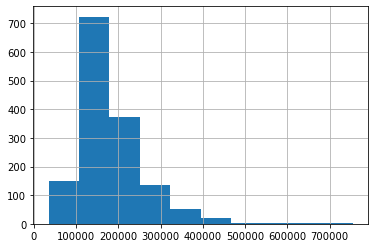

In [6]:
train_data['SalePrice'].hist()

In [7]:
train_data = train_data[train_data.GrLivArea < 4000]
train_data.reset_index(drop=True, inplace=True)
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])


In [8]:
y_train = train_data['SalePrice'].reset_index(drop=True)

In [9]:
test_data = test_data[test_data.GrLivArea < 4000]
test_data.reset_index(drop=True, inplace=True)

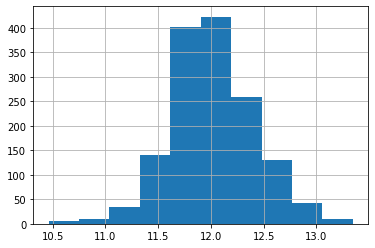

In [10]:
train_data['SalePrice'].hist()

Storing SalePrice column seperately , as it is the 'Y' label that our model will learn to predict. Not to be stored in 'X' or features.

In [11]:
train_data_features = train_data.drop(['SalePrice'], axis=1)
test_data_features = test_data
features = pd.concat([train_data_features, test_data_features]).reset_index(
    drop=True)
features = features[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF']]

In [12]:
# train_data_features.shape,train_data_features.describe(),train_data_features.columns

In [13]:
def get_missing_vals(features):
    data_features_na = features.isnull().sum()
    data_features_na = data_features_na[data_features_na>0]
    print(data_features_na.sort_values(ascending=False))

In [14]:
def missingValuesAssignment(features):
    categorical_feature_mask = features.dtypes==object
    categorical_cols = features.columns[categorical_feature_mask].tolist()
    
    features['GarageYrBlt'] = features['GarageYrBlt'].fillna(features['GarageYrBlt'].mean())
    features['MasVnrArea'] = features['MasVnrArea'].fillna(features['MasVnrArea'].mean())
    features['GarageCars'] = features['GarageCars'].fillna(features['GarageCars'].mean())
    features['GarageArea'] = features['GarageArea'].fillna(features['GarageArea'].mean())
    features['BsmtFinSF1'] = features['BsmtFinSF1'].fillna(features['BsmtFinSF1'].mean())
    features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(features['TotalBsmtSF'].mean())
    
    
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics.append(i)
    features.update(features[numerics].fillna(0))
        
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics2.append(i)
    skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    
    return features

In [15]:
features = missingValuesAssignment(features)

In [16]:
# train_data_features.shape
final_features = features

In [17]:
X_train = final_features.iloc[:len(y_train), :]
X_test = final_features.iloc[len(y_train):, :]
y_train = np.array(y_train).reshape([-1,1])
X_train.shape, y_train.shape, X_test.shape

((1456, 18), (1456, 1), (1458, 18))

In [18]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)


In [19]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)


In [21]:
train_predictions = lm.predict(X_train)

In [22]:
print('MAE:', metrics.mean_absolute_error(y_train, train_predictions))
print('MSE:', metrics.mean_squared_error(y_train, train_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, train_predictions)))

MAE: 0.24735947062514005
MSE: 0.11908648535702054
RMSE: 0.3450890977081434
